In [86]:
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import sklearn


from tensorflow import keras
from tensorflow.keras import models, callbacks, layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



Uploading datasets

In [87]:
import pathlib
dataset = "/content/drive/MyDrive/archive (3)/chest_xray"
dataset_train = "/content/drive/MyDrive/archive (3)/chest_xray/train"
dataset_validate = "/content/drive/MyDrive/archive (3)/chest_xray/test"

Cleaning of Data

In [88]:
from pathlib import Path
import imghdr

dataset = "/content/drive/MyDrive/archive (3)/chest_xray"
image_extns = {".png", ".svg", ".gif", ".jpg"}
tf_supported = {"bmp", "gif", "jpeg", "png"}

#converting to path format
dataset_path = Path(dataset)

for img_file in dataset_path.rglob("*"):
    if img_file.suffix.lower() in image_extns:
        img_type = imghdr.what(img_file)
        if not img_type:
            print(f"Skipped: {img_file} (unrecognized format)")
        elif img_type not in tf_supported:
            print(f"Warning: {img_file} is '{img_type}', not TF-compatible")

In [89]:
img_size = (180, 180)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)


Found 5226 files belonging to 2 classes.


In [90]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_validate,
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [91]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


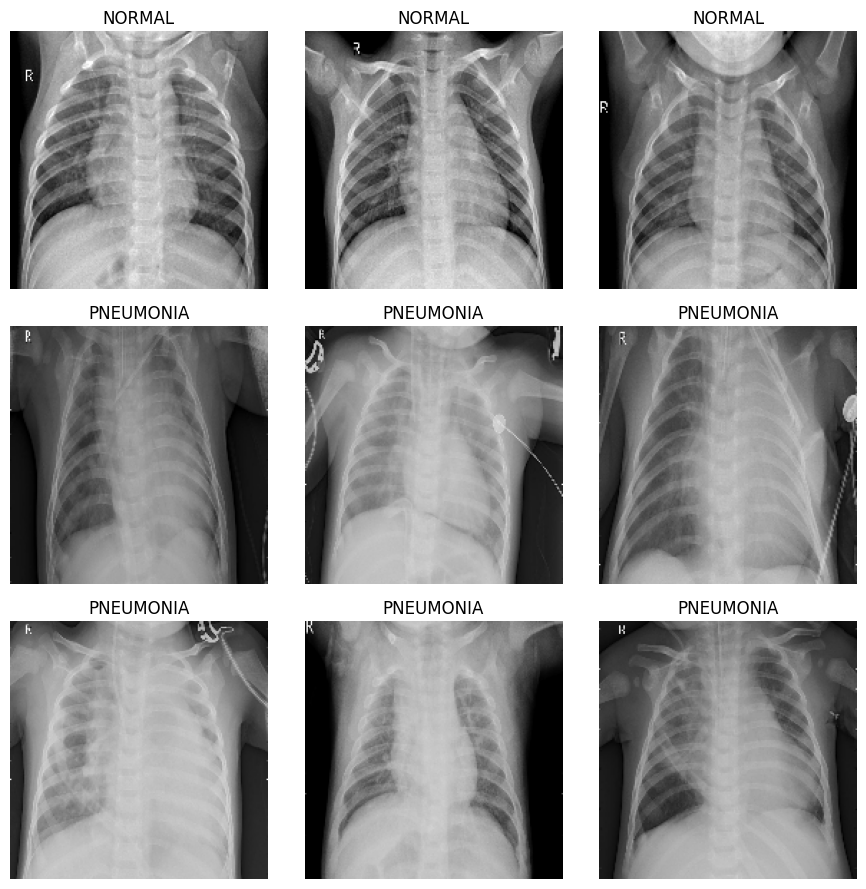

In [92]:
import matplotlib.pyplot as plt

sample_images, sample_labels = next(iter(train_ds))

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[sample_labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [93]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(180, 180, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])


In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [95]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.8680 - loss: 0.3084 - val_accuracy: 0.7196 - val_loss: 1.1466
Epoch 2/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.9695 - loss: 0.0891 - val_accuracy: 0.6875 - val_loss: 1.7693
Epoch 3/3
164/164 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9715 - loss: 0.0766 - val_accuracy: 0.7019 - val_loss: 1.9073


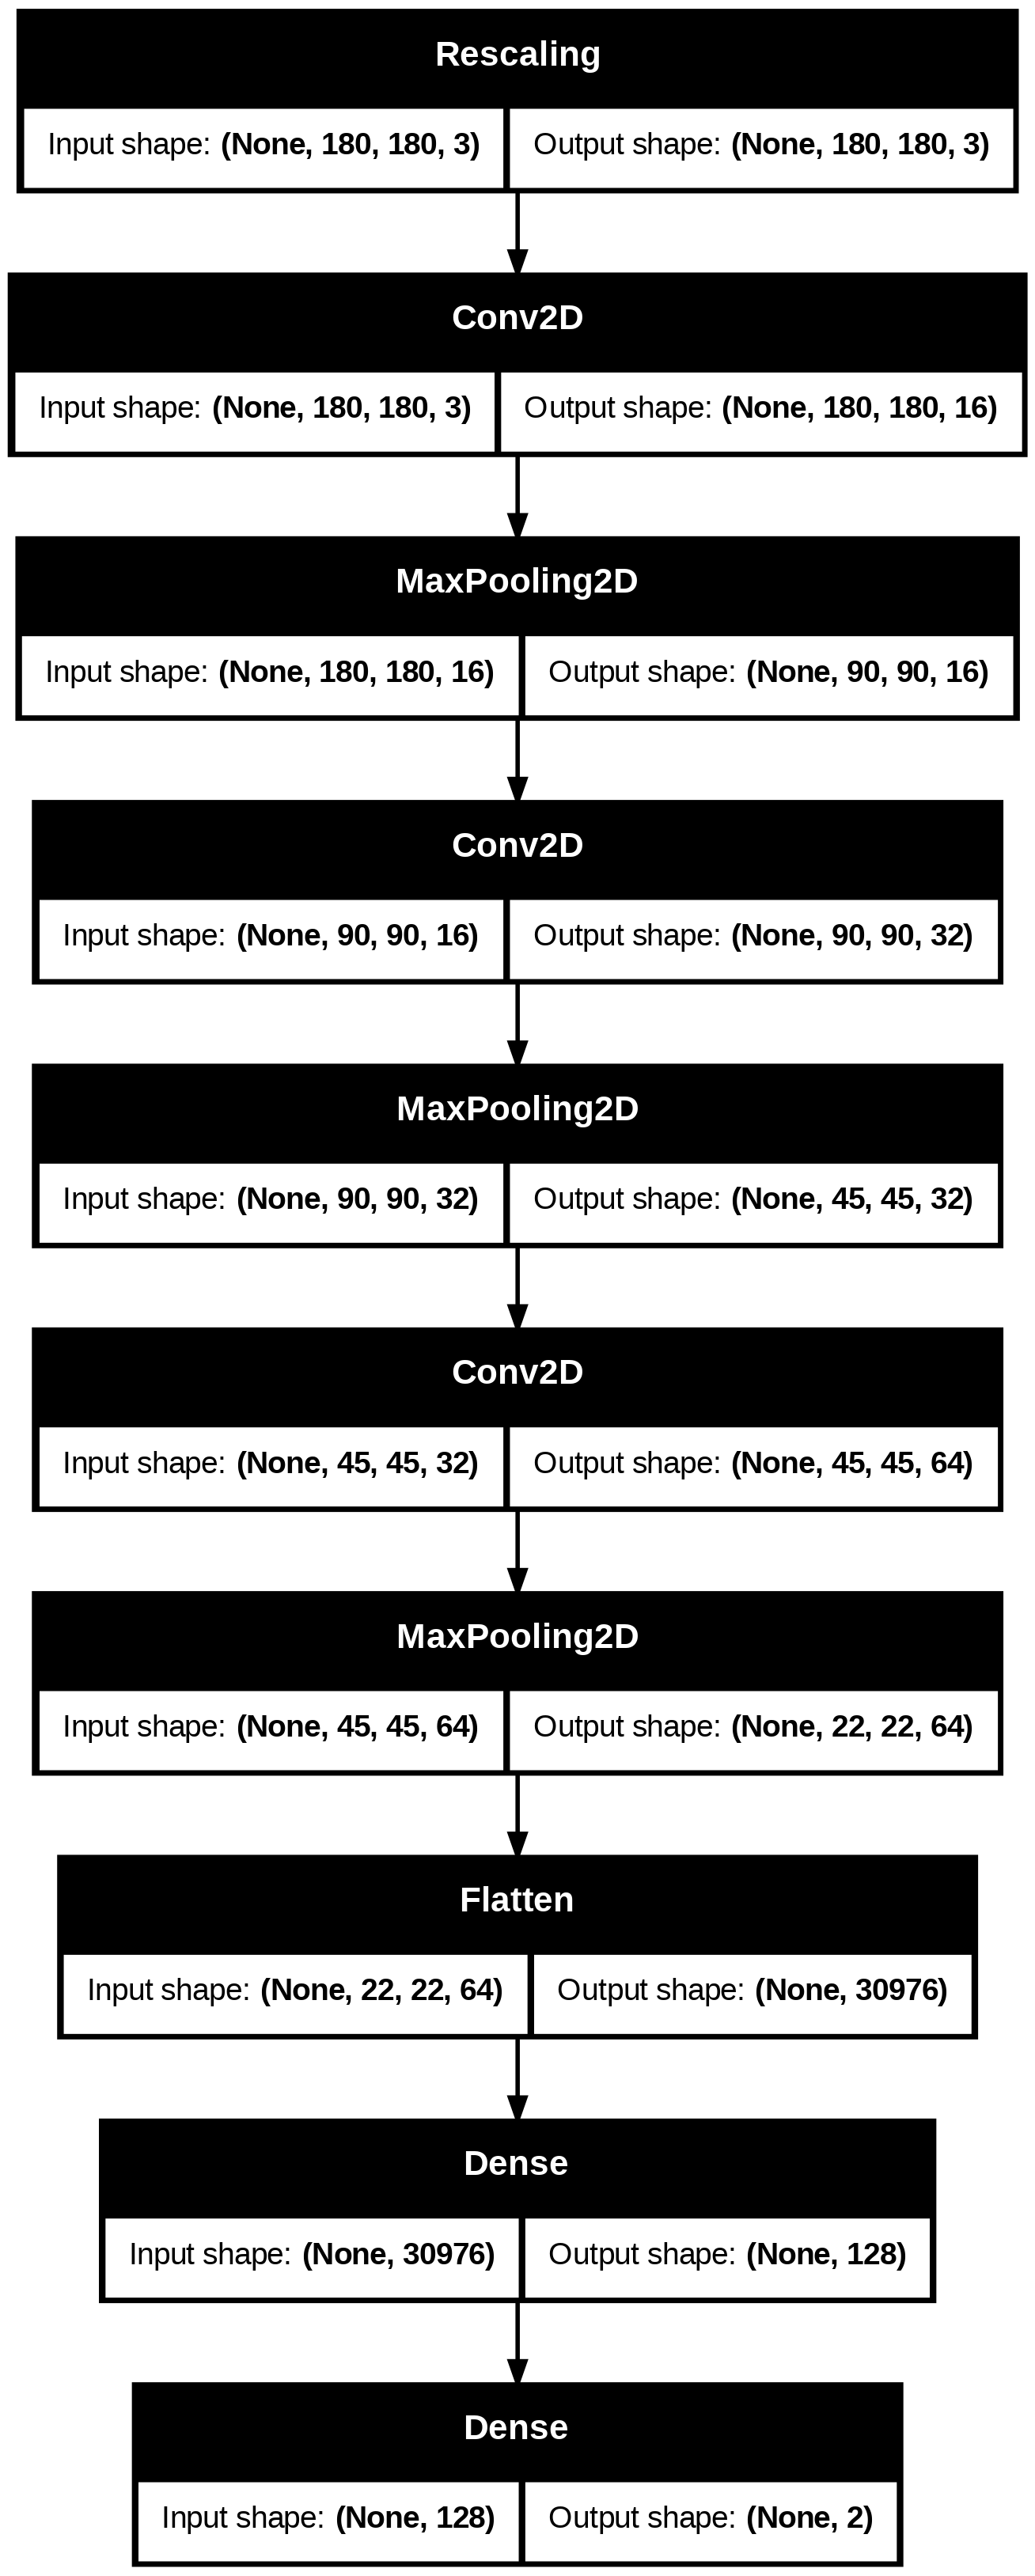

In [96]:
activation=2
keras.utils.plot_model(model, show_shapes=True)

In [100]:
tf.keras.models.save_model(model,'xray_model.hdf5')

In [109]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import cv2

# Load the model
try:
    model = tf.keras.models.load_model("my_model2.hdf5")
except Exception as e:
    print("Failed to load model:", e)
    model = None


def predict(img_path):
    img = Image.open(img_path)
    img = ImageOps.fit(img, (180, 180), Image.Resampling.LANCZOS)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    img = img[np.newaxis, ...]
    return model.predict(img)

# Run prediction
img_path = "/content/drive/MyDrive/archive (3)/chest_xray/chest_xray/test/NORMAL/IM-0003-0001.jpeg"

if model:
    try:
        probs = tf.nn.softmax(predict(img_path)[0])
        cls, conf = np.argmax(probs), 100 * np.max(probs)
        print(f"Predicted class: {cls} ({conf:.2f}% confidence)")
        print("Class probabilities:", np.round(probs * 100, 2), "%")
    except FileNotFoundError:
        print("Image file not found. Check the path.")
else:
    print("No model available for prediction.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predicted class: 1 (73.10% confidence)
Class probabilities: [26.9 73.1] %
